# GRAPE calculation of control fields for single-qubit rotation

Robert Johansson (robert@riken.jp)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

In [2]:
from qutip import *
from qutip.control import *

In [3]:
T = 1
times = np.linspace(0, T, 100)

In [43]:
#theta, phi = np.random.rand(2)
theta = np.pi/2
phi = np.pi/4

In [44]:
# target unitary transformation (random single qubit rotation)
U = rz(phi) * rx(theta); U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.65328148-0.27059805j -0.27059805-0.65328148j]
 [ 0.27059805-0.65328148j  0.65328148+0.27059805j]]

In [45]:
R = 150
H_ops = [sigmax(), sigmay(), sigmaz()]

H_labels = [r'$u_{x}$',
            r'$u_{y}$',
            r'$u_{z}$',
        ]

In [46]:
H0 = 0 * pi * sigmaz()

# GRAPE

In [27]:
from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

In [28]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [29]:
u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [30]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*pi/T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:   3.66s. Est. time left: 00:00:00:32
20.0%. Run time:   6.74s. Est. time left: 00:00:00:26
30.0%. Run time:   9.80s. Est. time left: 00:00:00:22
40.0%. Run time:  13.31s. Est. time left: 00:00:00:19
50.0%. Run time:  16.50s. Est. time left: 00:00:00:16
60.0%. Run time:  20.11s. Est. time left: 00:00:00:13
70.0%. Run time:  25.71s. Est. time left: 00:00:00:11
80.0%. Run time:  32.23s. Est. time left: 00:00:00:08
90.0%. Run time:  35.73s. Est. time left: 00:00:00:03
Total run time:  38.75s


## Plot control fields for iSWAP gate in the presense of single-qubit tunnelling

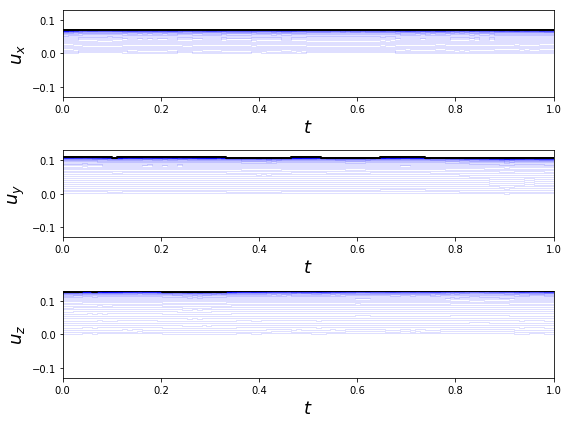

In [31]:
plot_grape_control_fields(times, result.u[:,:,:] / (2 * pi), H_labels, uniform_axes=True);

In [32]:
# target unitary
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.41324600-0.64359251j -0.54209049-0.3480723j ]
 [ 0.54209049-0.3480723j   0.41324600+0.64359251j]]

In [33]:
# unitary from grape pulse
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.41324600-0.64359251j -0.54209049-0.3480723j ]
 [ 0.54209049-0.3480723j   0.41324600+0.64359251j]]

In [34]:
# target / result overlap
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f))**2

(0.9999999999999987, 0.9999999999999973)

### Verify correctness of the Hamiltonian pulses by integration

In [35]:
c_ops = []

In [36]:
U_f_numerical = propagator(result.H_t, times[-1], c_ops, args={})

In [37]:
U_f_numerical

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.42015933-0.63598536j -0.54783000-0.34477682j]
 [ 0.54783000-0.34477682j  0.42015933+0.63598536j]]

In [38]:
_overlap(U, U_f_numerical)

(0.9999252674815007+0j)

# Bloch sphere dynamics

In [39]:
psi0 = basis(2, 0)
e_ops = [sigmax(), sigmay(), sigmaz()]

In [42]:
result?

In [40]:
me_result = mesolve(result.H_t, psi0, times, c_ops, e_ops)

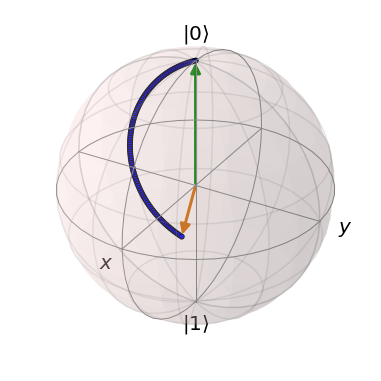

In [41]:
b = Bloch()

b.add_points(me_result.expect)

b.add_states(psi0)
b.add_states(U * psi0)
b.render()

# Process tomography

## Ideal gate

In [23]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
op_label = [["i", "x", "y", "z"]]

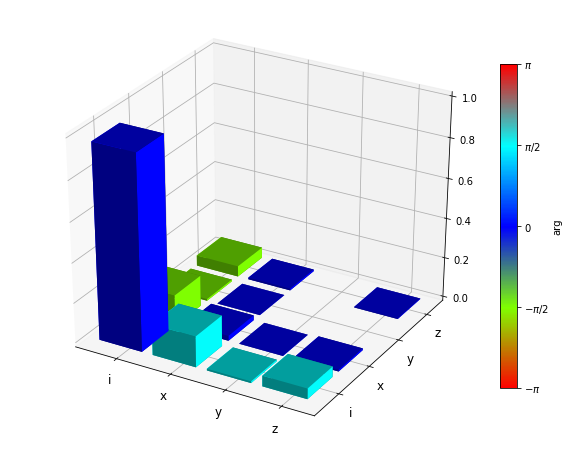

In [24]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(U) * spost(U.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Gate calculated using GRAPE

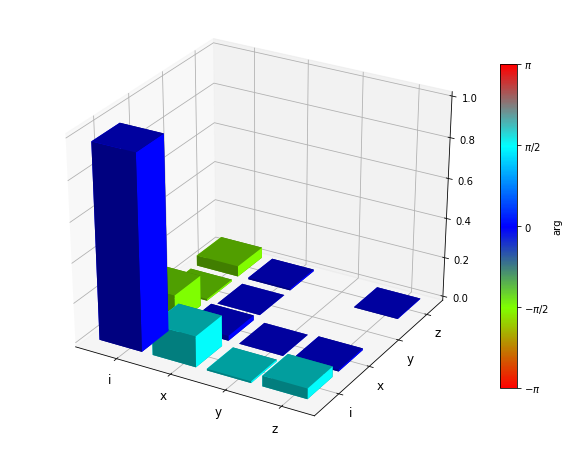

In [25]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(result.U_f) * spost(result.U_f.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Versions

In [26]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.25.2
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]"
OS,posix [darwin]
